In [2]:
import numpy as np
from scipy import signal, sparse
import skimage as sk
import skimage.filters as sf
import skimage.io as skio
from skimage.io import imsave, imshow, show

from operations import *

/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


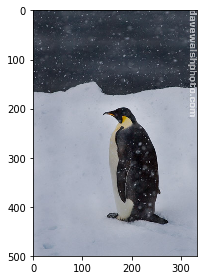

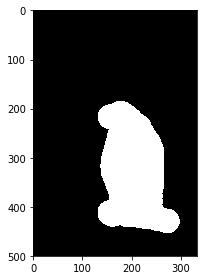

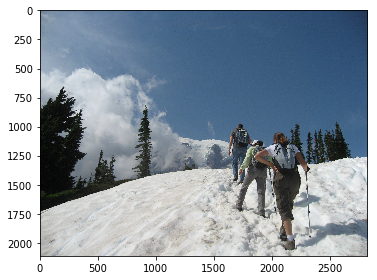

In [3]:
impathToy = 'sample_imgs/samples/toy_problem.png'
imT = skio.imread(impathToy)
imT = sk.img_as_float(imT)

impathM = 'sample_imgs/spline/mask2.jpg'
imM = skio.imread(impathM)
imM = sk.img_as_float(imM)

impathToyMask = 'sample_imgs/samples/toy_problem mask.png'
imToyMask = skio.imread(impathToyMask)
imToyMask = sk.img_as_float(imToyMask)
# viewImage(imToyMask)

impathToyMaskMix = 'sample_imgs/samples/toy_problem mask_mix.png'
imToyMaskMix = skio.imread(impathToyMaskMix)
imToyMaskMix = sk.img_as_float(imToyMaskMix)
# viewImage(imToyMaskMix)

impathToyCol = 'sample_imgs/samples/toy_problem_color.png'
imToyCol = skio.imread(impathToyCol)
imToyCol = sk.img_as_float(imToyCol)
# viewImage(imToyMask)

impathPengChick = 'sample_imgs/samples/penguin-chick.jpeg'
imPengChick = skio.imread(impathPengChick)
imPengChick = sk.img_as_float(imPengChick)
# viewImage(imPengChick)

impathPeng = 'sample_imgs/samples/penguin.jpg'
imPeng = skio.imread(impathPeng)
imPeng = sk.img_as_float(imPeng)
viewImage(imPeng)

impathPengMask = 'sample_imgs/samples/penguin_mask.png'
imPengMask = skio.imread(impathPengMask)
imPengMask = sk.img_as_float(imPengMask)
viewImage(imPengMask)

impathIm3 = 'sample_imgs/samples/im3.jpg'
imIm3 = skio.imread(impathIm3)
imIm3 = sk.img_as_float(imIm3)
viewImage(imIm3)

In [4]:
mask = np.ones(imT.shape)

def createNonZeroPairs(mask):
    #TODO extend
    if mask.ndim == 3:
        mask = np.squeeze(np.dsplit(mask, [1])[0], axis=2)
        # change 3 channel to 1 value per pixel,
        # specifically using the 0th channel's
    maskNonZero = mask.nonzero()
    
#    return maskNonZero
    
    nonZeroIndices = []
#    mask
    for i in range(len(maskNonZero[0])):
        nonZeroIndices.append((maskNonZero[0][i], maskNonZero[1][i]))
    
    return nonZeroIndices

#####
# mask.nonzero() ## assume it's 1D

def makeIm2Var(mask):
    nonZeroIndices = createNonZeroPairs(mask)
    
    maskHeight, maskWidth = mask.shape
    # print("weepweep: ", maskHeight, maskWidth)

    dictIm2Var = dict()
    dictVar2Im = dict()
    
    dictRow2Cols = dict()
    dictCol2Rows = dict()

    fTup2Key = (lambda tup: "%i-%i" % tup)
    fYX2Key = (lambda y, x: fTup2Key((y, x)))

    for i in range(len(nonZeroIndices)):
        pair = nonZeroIndices[i]
        row, col = pair
        
        if row not in dictRow2Cols:
            dictRow2Cols[row] = []
        dictRow2Cols[row].append(col)
        
        if col not in dictCol2Rows:
            dictCol2Rows[col] = []
        dictCol2Rows[col].append(row)
        
        key = fTup2Key(pair)
        dictIm2Var[key] = i
        dictVar2Im[i] = pair

    im2Var = (lambda y, x: dictIm2Var[fYX2Key(y, x)])
    var2Im = (lambda x: dictVar2Im[x])
    totalUnknowns = len(nonZeroIndices)
    
    dictCol2Borders = dict()
    dictRow2Borders = dict()
    
    def getColBorders(col, mode):
        if mode == "ltr":
            mode = 0
        elif mode == "rtl":
            mode = 1
        elif mode == "both":
            mode = 2
        else:
            raise Exception("unrecognized mode")
        return dictCol2Borders[col][mode]
    def getRowBorders(row, mode):
        if mode == "ltr":
            mode = 0
        elif mode == "rtl":
            mode = 1
        elif mode == "both":
            mode = 2
        else:
            raise Exception("unrecognized mode")
        return dictRow2Borders[row][mode]


    for col, rows in dictCol2Rows.items():
        dictCol2Borders[col] = findBorders(rows, maskHeight - 1)
    for row, cols in dictRow2Cols.items():
        dictRow2Borders[row] = findBorders(cols, maskWidth - 1)
    
    # print(dictIm2Var)
    return im2Var, var2Im, totalUnknowns, dictRow2Cols, dictCol2Rows, getColBorders, getRowBorders

# im2Var, var2Im, totalUnknowns, dictRow2Cols, dictCol2Rows, getColBorders, getRowBorders = makeIm2Var(mask)

# im2Var(3, 2)

In [42]:
targetYX = (1576, 1088)
imTarg = imIm3
imSrc = imPeng
srcMask = imPengMask
# targetYX = (0, 0)
# imTarg = imToyCol
# imSrc = imToyCol
# srcMask = imToyMaskMix
newImSrc, newSrcMask = shiftObjectNMask(targetYX, imSrc, srcMask, imTarg)

im2Var, var2Im, totalUnknowns, dictRow2Cols, dictCol2Rows, getColBorders, getRowBorders = makeIm2Var(newSrcMask)

2112 2816


In [47]:
def getPixelWCC(im, y, x, colorChannelCt):
    if colorChannel == 1:
        return im[y, x]
    elif colorChannel == 3:
        return im[y, x, colorChannel]
    else:
        raise Exception("Unrecognized colorChannelCt:" + str(colorChannelCt))

Starting LSQR, color channel: 0
Finished LSQR, color channel: 0
Starting LSQR, color channel: 1
Finished LSQR, color channel: 1
Starting LSQR, color channel: 2
Finished LSQR, color channel: 2


/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


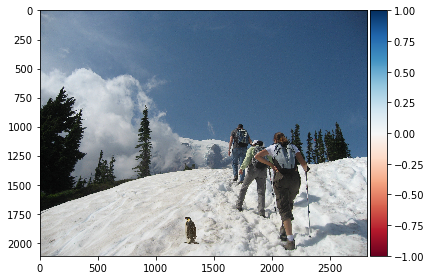

In [45]:

# totalUnknowns = rHeight * rWidth #change

if imTarg.ndim == 3:
    maxHeightInd, maxWidthInd,  colorChannelCt = imTarg.shape
elif imTarg.ndim == 2:
    maxHeightInd, maxWidthInd = imTarg.shape
    colorChannelCt = 1
else:
    raise Exception("...unrecognized ndim?")
maxHeightInd -= 1
maxWidthInd -= 1

rHeight, rWidth = len(dictRow2Cols), len(dictCol2Rows)
finalIm22 = np.matrix.copy(imTarg)

# print(maxHeightInd, maxWidthInd)

totalAFinished = False

for colorChannel in range(colorChannelCt):

    neg1_changeListY = []
    neg1_changeListX = []
    pos1_changeListY = []
    pos1_changeListX = []

    # def neg1(y, x):

    bList = []

    newLineCt = -1
    for y, cols in dictRow2Cols.items():
        # cols = dictRow2Cols[y]
        if len(cols) <= 1:
            continue

        for col in cols:
            if col == maxWidthInd or col in getRowBorders(y, "rtl"):
                continue
            newLineCt += 1
            bList.append(newImSrc[y, col+1, colorChannel] - newImSrc[y, col, colorChannel])
            if totalAFinished:
                continue
            neg1_changeListY.append(newLineCt)
            neg1_changeListX.append(im2Var(y, col))

            pos1_changeListY.append(newLineCt)
            pos1_changeListX.append(im2Var(y, col+1))

    for x, rows in dictCol2Rows.items():
        if len(rows) <= 1:
            continue

        for row in rows: # in range(len(rows) - 1):
            if row == maxHeightInd or row in getColBorders(x, "rtl"):
                continue
            newLineCt += 1
            bList.append(newImSrc[row+1, x, colorChannel] - newImSrc[row, x, colorChannel])            
            if totalAFinished:
                continue
            neg1_changeListY.append(newLineCt)
            neg1_changeListX.append(im2Var(row, x))

            pos1_changeListY.append(newLineCt)
            pos1_changeListX.append(im2Var(row+1, x))


    # print(neg1_changeListY)
    # print(neg1_changeListX)
    # print(pos1_changeListY)
    # print(pos1_changeListX)

    ## TOY PROB corner match
#     if imSrc == imT and imTarg == imT:
#         newLineCt += 1
#         pos1_changeListY.append(newLineCt)
#         pos1_changeListX.append(im2Var(0, 0))
#         bList.append(newImSrc[0, 0, , colorChannel])

#     ## original A construction
#     newA = np.zeros((newLineCt + 1, totalUnknowns))

#     newA[neg1_changeListY,neg1_changeListX] = -1
#     newA[pos1_changeListY,pos1_changeListX] = 1
    
    b = np.array(bList)
    
    
    outReg_neg1_changeListY = []
    outReg_neg1_changeListX = []
    outReg_pos1_changeListY = []
    outReg_pos1_changeListX = []

    outReg_bList = []

    outReg_LineCt = newLineCt

    for row in dictRow2Cols:
        for i in getRowBorders(row, "ltr"):
            # print("before:", outReg_LineCt)
            outReg_LineCt += 1
            # outReg_bList.append(imTarg[row, i+1, colorChannel])
            outReg_bList.append(imTarg[row, i+1, colorChannel] + newImSrc[row, i, colorChannel] - newImSrc[row, i+1, colorChannel])

            if totalAFinished:
                continue
            outReg_pos1_changeListY.append(outReg_LineCt)
            outReg_pos1_changeListX.append(im2Var(row, i))
            # print("LTR row: ", outReg_LineCt, im2Var(row, i))
        for j in getRowBorders(row, "rtl"):
            outReg_LineCt += 1
            # outReg_bList.append(imTarg[row, j-1, colorChannel])
            outReg_bList.append(imTarg[row, j-1, colorChannel] + newImSrc[row, j, colorChannel] - newImSrc[row, j-1, colorChannel])
            
            if totalAFinished:
                continue
            outReg_pos1_changeListY.append(outReg_LineCt)
            outReg_pos1_changeListX.append(im2Var(row, j))
            # print("RTL row: ", outReg_LineCt, im2Var(row, j))
    for col in dictCol2Rows:
        for m in getColBorders(col, "ltr"):
            outReg_LineCt += 1
            # outReg_bList.append(imTarg[m+1, col, colorChannel])
            outReg_bList.append(imTarg[m+1, col, colorChannel] + newImSrc[m, col, colorChannel] - newImSrc[m+1, col, colorChannel])
            
            if totalAFinished:
                continue
            outReg_pos1_changeListY.append(outReg_LineCt)
            outReg_pos1_changeListX.append(im2Var(m, col))
        for n in getColBorders(col, "rtl"):
            outReg_LineCt += 1
            # outReg_bList.append(imTarg[n-1, col, colorChannel])
            outReg_bList.append(imTarg[n-1, col, colorChannel] + newImSrc[n, col, colorChannel] - newImSrc[n-1, col, colorChannel])
            
            if totalAFinished:
                continue
            outReg_pos1_changeListY.append(outReg_LineCt)
            outReg_pos1_changeListX.append(im2Var(n, col))

#     # pre sparse A
#     outReg_A = np.zeros((outReg_LineCt + 1, totalUnknowns))

#     # print(outReg_pos1_changeListY)
#     # print(outReg_pos1_changeListX)

#     outReg_A[outReg_neg1_changeListY,outReg_neg1_changeListX] = -1
#     outReg_A[outReg_pos1_changeListY,outReg_pos1_changeListX] = 1
    
    # newA
    outReg_b = np.array(outReg_bList)
    
    # print(b.shape, outReg_b.shape)
    
    
    
    ### FINAL FORM
    if not totalAFinished:
        # totalA = np.vstack((newA, outReg_A))
        final_neg1_changeListX = neg1_changeListX + outReg_neg1_changeListX
        final_neg1_changeListY = neg1_changeListY + outReg_neg1_changeListY
        final_pos1_changeListX = pos1_changeListX + outReg_pos1_changeListX
        final_pos1_changeListY = pos1_changeListY + outReg_pos1_changeListY

        assert len(final_pos1_changeListX) == len(final_pos1_changeListY)
        assert len(final_neg1_changeListX) == len(final_neg1_changeListY)

        final_all_changeListY = final_neg1_changeListY + final_pos1_changeListY
        final_all_changeListX = final_neg1_changeListX + final_pos1_changeListX
        final_all_dataList = [-1] * len(final_neg1_changeListY) + [1]  * len(final_pos1_changeListY)

        # print(outReg_LineCt, totalUnknowns, ":", max(final_all_changeListY), max(final_all_changeListX))
        totalA = sparse.csr_matrix((final_all_dataList, (final_all_changeListY, final_all_changeListX)), (outReg_LineCt + 1, totalUnknowns))

        totalAFinished = True
    totalB = np.hstack((b, outReg_b))

    print("Starting LSQR, color channel:", colorChannel)
    resolve2222 = sparse.linalg.lsqr(totalA, totalB)
    print("Finished LSQR, color channel:", colorChannel)

    # finalIm22[0, 0] = 0
    # finalIm22[0, 1] = 0

    ## you have to figure out how to do this w color pics
    sol2222 = resolve2222[0]
    sol2222 = np.clip(sol2222, -1, 1)
    for varId, value in enumerate(sol2222):
        hei, wid = var2Im(varId)
        finalIm22[hei, wid, colorChannel] = value

testImage("pengies.png", finalIm22)


In [ ]:
# bnewA, bb

# testt = []
# testtb = []
# testttt = []
# testtttb = []
# for row in dictRow2Cols:
#     for i in getRowBorders(row, "ltr"):
#         testt.append((row, i))
#         testttt.append(im2Var(row, i))
#     for j in getRowBorders(row, "rtl"):
#         testtb.append((row, j))
#         testtttb.append(im2Var(row, j))
# print(testt)
# print(testtb)
# print(testttt)
# print(testtttb)
# print(bnewA.nonzero()[1])

In [ ]:
resolve = sparse.linalg.lsqr(newA, b)

In [ ]:
# newA.shape, outReg_A.shape
b.shape, outReg_b.shape

In [ ]:
"""
matchback var id to im coord
create new photo where
    if in region, use the var id
    else if outregion, use target image
"""



In [ ]:
# asda = newSrcMask == 1
# print(newSrcMask.shape, asda.shape)



In [ ]:
# reconstruct from solution 2 im

finalIm = np.zeros((rHeight, rWidth)) #watch this break lmao

solution = resolve[0]

# for x in enumerate(solution):
#     print(x)

for varId, sol in enumerate(solution):
    # print(var2Im(varId))
    
    y, x = var2Im(varId)
    
    finalIm[y, x] = sol

testImage("hooo5.png", finalIm)

In [6]:
def findBorders(row, maxIndex):
#     if mode == "rtl":
#         RTL = True
#         LTR = False
#     elif mode == "ltr":
#         RTL = False
#         LTR = True
#     elif mode == "both":
#         RTL = True
#         LTR = True
    """
    input = [1, 2, 5, 6]
    output = [2, 5]
    # q: do we care about image boundary boundaries
    # a: no, it'll eff up the algo -- if you need image boundary stuff
    # add it separately on the algo
    """
    assert row[-1] <= maxIndex

    ltrBorders = set()
    rtlBorders = set()
    
    if len(row) == 0:
        return borders
    
    minIndex = 0
        
    diff = [row[0] - (minIndex - 1)]
    for i in range(1, len(row)):
        diff.append(row[i] - row[i-1])
    diff.append(maxIndex + 1 - row[-1])
    # print(diff)
    
    for ind, val in enumerate(diff):
        if val > 1:
            # if RTL:
            if ind - 1 >= 0: # comment this out to get left to right edge
                rtlBorders.add(row[ind - 1])
            #if LTR:
            if ind < len(row): # comment this out to get right to left edge
                ltrBorders.add(row[ind])
    
    return ltrBorders, rtlBorders, ltrBorders.union(rtlBorders)

findBorders([0, 2, 4, 5, 6, 7], 8)

({2, 4}, {0, 2, 7}, {0, 2, 4, 7})

In [5]:

# def shiftObjectNMask(imSrc, srcMask, imTarg):
# imTarg = np.zeros([5,5])
# imSrc = np.dot(3, np.ones([2,2]))
# srcMask = np.ones([2,2])
tt_targetYX = (0, 0)

###

def shiftObjectNMask(targetYX, imSrc, srcMask, imTarg):

    if imTarg.ndim == 3:
        targHeight, targWid, _ = imTarg.shape
    elif imTarg.ndim == 2:
        targHeight, targWid = imTarg.shape

    if imSrc.ndim == 3:
        srcHeight, srcWid, _ = imSrc.shape
    elif imSrc.ndim == 2:
        srcHeight, srcWid = imSrc.shape

    # print(srcMask.shape)
    assert (srcHeight, srcWid) == srcMask.shape
    assert targWid and targHeight and srcWid and srcHeight

    rowStart = targetYX[0]
    rowEnd = targetYX[0]+srcHeight
    colStart = targetYX[1]
    colEnd = targetYX[1]+srcWid

    if rowStart < 0 or rowEnd > targHeight or colStart < 0 or colEnd > targWid:
        raise Exception("source img doesn't fit target img in the given location: %s" % str(img))
        
    print(targHeight, targWid)

    if imSrc.ndim == 3:
        newImSrc = np.zeros((targHeight, targWid, 3))
        newImSrc[rowStart:rowEnd, colStart:colEnd, 0] = imSrc[:, :, 0]
        newImSrc[rowStart:rowEnd, colStart:colEnd, 1] = imSrc[:, :, 1]
        newImSrc[rowStart:rowEnd, colStart:colEnd, 2] = imSrc[:, :, 2]
    elif imSrc.ndim == 2:
        newImSrc = np.zeros((targHeight, targWid))
        newImSrc[rowStart:rowEnd, colStart:colEnd] = imSrc
    
    newSrcMask = np.zeros((targHeight, targWid))
    newSrcMask[rowStart:rowEnd, colStart:colEnd] = srcMask
    
    return newImSrc, newSrcMask

    ####

# imTarg, imSrc

# newww, newwm = shiftObjectNMask(tt_targetYX, imToyCol, imToyMask, imPengChick)
# print(imPengChick.shape)

# viewImage(newww)
# viewImage(newwm)
# viewImage(imPengChick)

#  newww



In [ ]:
np.array([1]).shape == np.array([1]).shape 

In [ ]:
"""
for every row:
    for every pixel I in ltr:
        add to A a 1 in position im(row, I)
        add to B = imTarg[I+1]
        #just get ready to change this shit to imTarg[row, I+1] - imTarg[row, I]
    for every pixel I in rtl:
        add to A a 1 in position im(row, I)
        add to B = imTarg[row, I-1]
        #just get ready to change this shit to imTarg[row, I] - imTarg[row, I-1]

for every col:
    for every pixel J in ltr:
        add to A a 1 in position im(J, col)
        add to B = imTarg[J+1, col]
        #just get ready to change this shit to imTarg[J+1, col] - imTarg[J, col]
    for every pixel J in rtl:
        add to A a 1 in position im(J, col)
        add to B = imTarg[J-1, col]
        #just get ready to change this shit to imTarg[J, col] - imTarg[J-1, col]
    
"""

In [ ]:
"""
neg1_changeListY = []
neg1_changeListX = []

pos1_changeListY = []
pos1_changeListX = []

### X-DIR GRADIENTS
per y row:
    if size of region in this row is 1 or less:
        continue
    increase newLineCt
    for every pixel i in the row except last one:
        neg1_changeListY.append(newLineCt)
        neg1_changeListX.append(im2Var(y, i))
        
        pos1_changeListY.append(newLineCt)
        pos1_changeListX.append(im2Var(y, i+1))
        # first index = most left in region
        # last index = most right in region
per x cols:
    if size of region in this column is 1 or less:
        continue
    increase newLineCt
    for pix j in this col except last one:
        neg1_changeListY.append(newlineCt)
        neg1_changeListX.append(im2Var(j, x))
        
        pos1_changeListY.append(newlineCt)
        pos1_changeListX.append(im2Var(j+1, x))

"""

In [ ]:
# impath1 = 'sample_imgs/spline/apple.jpeg'
# im1 = skio.imread(impath1)
# im1 = sk.img_as_float(im1)

# impath2 = 'sample_imgs/spline/orange.jpeg'
# im2 = skio.imread(impath2)
# im2 = sk.img_as_float(im2)

# impathM = 'sample_imgs/spline/mask2.jpg'
# imM = skio.imread(impathM)
# imM = sk.img_as_float(imM)

In [ ]:
def scaler(LM): # scales to 0 1
    return np.dot(LM - LM.min(), 1 / (LM.max() - LM.min()))# * 2 - 1

def multiResBlendOp(im1, im2, mask, levels, sigma):
    assert im1.shape == im2.shape == mask.shape

    L1 = laplacianPyrOp_3D(im1, levels, sigma)
    L2 = laplacianPyrOp_3D(im2, levels, sigma)
    LM = gaussStackOp_3D(mask, levels, sigma) # laplacianPyrOp_3D(mask, levels, sigma)
    
    # LM_blur = gaussStackOp_3D(mask, levels, sigma)
    
    for i in range(len(L1)):
        viewImage(LM[i])
    
#     LM1 = np.dot(LM - LM.min(), 1 / (LM.max() - LM.min())) ## scale LM to [0, 1]
#     LM1 = LM1

#     print(LM.min(), LM.max())
    LM1 = LM
    LM2 = (1 - LM1)
    
#     print("HELP: ", LM1[0, 0, 0, 0], LM2[0, 0, 0, 0])
#     print(L1.min(), L1.max())
#     print(L2.min(), L2.max())
#     return
    
    L1_post = LM1 * L1 
    for i in range(len(L1)):
        viewImage(scaler(L1_post[i]))
    L2_post = LM2 * L2
    
    finalL =  L1_post + L2_post

    # levelsDim, heightDim, widthDim, channelDim = L1.shape
    
    tes = np.zeros(L1[0].shape)
    
    for i in range(len(L1)):
        viewImage(scaler(finalL[i]))
        tes += finalL[i]
    
    viewImage(tes)
    
#     for i in range(len(L1)):
#         viewImage(L1[i])

    
    # print(LM)
    

multiResBlendOp(im1, im2, imM, 10, 10)

In [ ]:
a = np.array([
    [
        [3, 3, 3], [1, 1, 1]
    ], # 1st row
    [
        [3, 3, 3], [1, 1, 1]
    ], # 2nd row
])
b = np.array([
    [
        [1, 2, 1]
    ],
    [
        [1, 1, 1]
    ]
])

#to convert 3-channel to just one of the channels, primarily the 0th one
np.squeeze(np.dsplit(a, [1])[0], axis=2)

In [ ]:
cccc = np.zeros((4, 4))
cccc[(1, 1)] = 1
cccc

In [ ]:
# im = im1
# im2 = gaussBlurOp_3D(im, sigma=20)
# viewImage(im)
# viewImage(im2)
# res = im - im2
# print(res.min(), res.max())
# result = (res - res.min())/(res.max()-res.min())
# #viewImage(np.dot(res, 255))
# viewImage(result)